In [18]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
igbo_df = pd.read_csv("data/igbo.tsv", sep="\t")
yoruba_df = pd.read_csv("data/yoruba.tsv", sep="\t")
hausa_df = pd.read_csv("data/hausa.tsv", sep="\t")


In [20]:
igbo_df = igbo_df[["tweet"]].rename(columns={"tweet": "text"})
igbo_df["language"] = "igbo"

yoruba_df = yoruba_df[["tweet"]].rename(columns={"tweet": "text"})
yoruba_df["language"] = "yoruba"

hausa_df = hausa_df[["tweet"]].rename(columns={"tweet": "text"})
hausa_df["language"] = "hausa"


In [21]:
df = pd.concat([igbo_df, yoruba_df, hausa_df], ignore_index=True)

print(df.sample(5))
print(df["language"].value_counts())


                                                    text language
7406   @user @user Okpa di Oku! Say it... Okpa di Oku!!!     igbo
12868  Ewé ọmurun wà, ewé gbégbé, gbòdògì, iran àti b...   yoruba
7576                  @user 😊😊 Dalụ rinne.. Nsogbu adiro     igbo
12751  Ẹ wí fún ilé ìgbìmọ̀ @user kí wọ́n dí isà ejò ...   yoruba
9143   @user @user @user @user @user @user @user @use...     igbo
language
hausa     14172
igbo      10192
yoruba     8522
Name: count, dtype: int64


In [22]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)   # remove URLs
    text = re.sub(r"[^a-zA-ZÀ-ſ\s]", "", text)  # keep letters (incl. accents)
    text = re.sub(r"\s+", " ", text).strip()    # remove extra spaces
    return text

df["clean_text"] = df["text"].apply(clean_text)

# Sanity check
df[["text", "clean_text", "language"]].sample(5)


,text,clean_text,language
9416,"#MinisteringInSong- song-' Obi naso,mma mma Ch...",ministeringinsong song obi nasomma mma chineke...,igbo
5698,"@user Mama Nise says, Uche bu akpa, onye odu n...",user mama nise says uche bu akpa onye odu nya ...,igbo
31169,@user Gaskiya wannan video yayi kyau sosai kum...,user gaskiya wannan video yayi kyau sosai kuma...,hausa
27649,@user Manya sunfara nasu 😁,user manya sunfara nasu,hausa
7131,"@user Ngwa bianu, Onye Nkem... ututu Oma 🌹",user ngwa bianu onye nkem ututu oma,igbo


In [23]:
# Features and labels
X = df["clean_text"]
y = df["language"]

# TF-IDF with character n-grams
vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=2
)

X_tfidf = vectorizer.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (32886, 223951)


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 26308
Test size: 6578


In [25]:
# Initialize model
model = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

# Train
model.fit(X_train, y_train)

print("Model training complete.")


Model training complete.


Classification Report:
              precision    recall  f1-score   support

       hausa       1.00      1.00      1.00      2835
        igbo       1.00      1.00      1.00      2039
      yoruba       1.00      1.00      1.00      1704

    accuracy                           1.00      6578
   macro avg       1.00      1.00      1.00      6578
weighted avg       1.00      1.00      1.00      6578



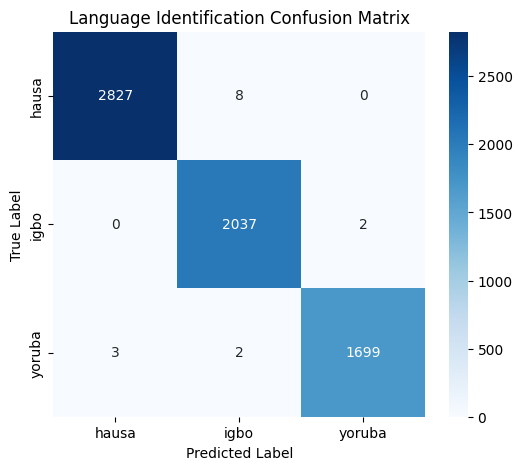

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=model.classes_,
    yticklabels=model.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Language Identification Confusion Matrix")
plt.show()
